<a href="https://colab.research.google.com/github/rubanzasilva/nn_scratch/blob/main/nn_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from ipywidgets import interact
from fastai.basics import *

plt.rc('figure', dpi=90)

def plot_function(f, title=None, min=-2.1, max=2.1, color='r', ylim=None):
    x = torch.linspace(min,max, 100)[:,None]
    if ylim: plt.ylim(ylim)
    plt.plot(x, f(x), color)
    if title is not None: plt.title(title)

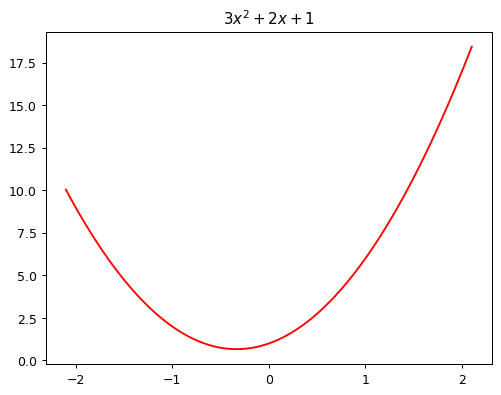

In [2]:
def f(x): return 3*x**2 + 2*x + 1

plot_function(f, "$3x^2 + 2x + 1$")

In [3]:
def quad(a, b, c, x):
  return a*x**2 + b*x + c

In [4]:
f4 = quad(3,2,1,2)
f4

17

In [5]:
def mk_quad(a,b,c):
  return partial(quad, a,b,c)

In [6]:
f2 = mk_quad(3,2,1)
f2(4)

57

In [7]:
#f2(2) should be the same as f4 with 2 as the given x
f2(2)


17

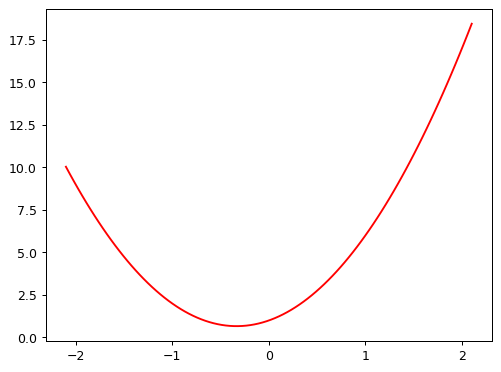

In [8]:
plot_function(f2)

Lets create random data and add noise to it.

We shall try to see if we can recreate our original function from the data we define.

In [9]:
def noise(x, scale): return np.random.normal(scale=scale, size=x.shape)
def add_noise(x, mult, add): return x * (1+noise(x,mult)) + noise(x,add)

In [10]:
np.random.seed(42)

x = torch.linspace(-2, 2, steps=20)[:,None]
y = add_noise(f(x), 0.15, 1.5)

In [11]:
print(torch.numel(x))

20


In [12]:
x[:4],y[:4]

(tensor([[-2.0000],
         [-1.7895],
         [-1.5789],
         [-1.3684]]),
 tensor([[11.8690],
         [ 6.5433],
         [ 5.9396],
         [ 2.6304]], dtype=torch.float64))

Lets plot our data to get a better picture

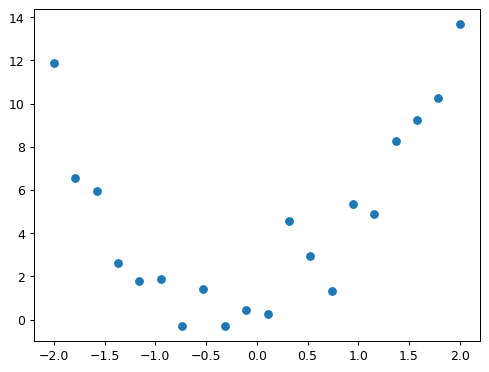

In [13]:
#(horizontal,vertical)
plt.scatter(x,y);

So our job here is to fit our quadratic function to the data plotted above.

We can manually do this by trying a few random parameters at first and adjusting the parameters in the direction of adjustment brings our function closer to fitting the data.

Later on we shall try to do this automatically using gradient descent.

We define a function plot_quad which overlays a quadratic on top of our data alongside some convient sliders which represent the parameters of the function.

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

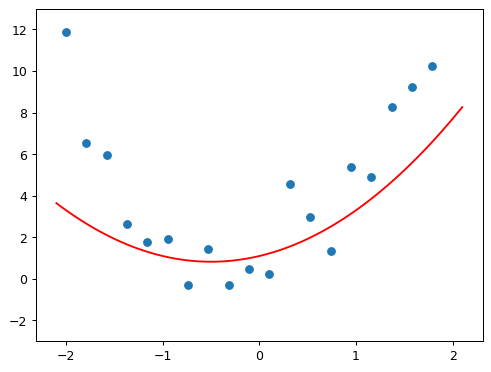

In [14]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    plt.scatter(x,y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13))

So first we find out which direction improves the fit of the quadratic to the data then drill down.

One issue we are going to face is we have no idea apart from manually looking at the plot whether our fit is better or worse.


To solve this we can use a metric, which measures our distance from our values to the target.In this case we use mean squared error.To improve our fit we need to minimize the mae.

In [15]:
def mae(preds,targets):
  return (torch.abs(preds-targets)).mean()

We now update our interactive plot_quad function to include our metric and printout for every parameter value change.

interactive(children=(FloatSlider(value=1.1, description='a', max=3.3000000000000003, min=-1.1), FloatSlider(v…

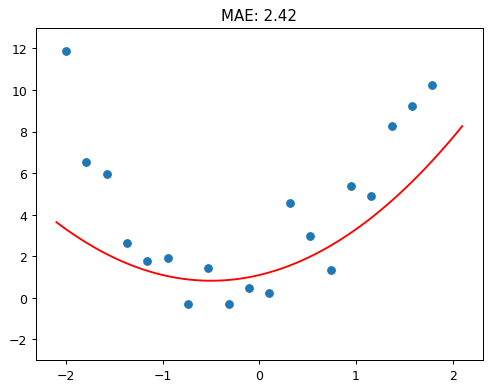

In [16]:
@interact(a=1.1, b=1.1, c=1.1)
def plot_quad(a, b, c):
    f = mk_quad(a,b,c)
    plt.scatter(x,y)
    loss = mae(f(x),y)
    plot_function(mk_quad(a,b,c), ylim=(-3,13), title=f"MAE: {loss:.2f}")

A modern day neural network has thousands or millions of parameters and manually adjusting sliders to adjust the parameters is quite impractical. What we would need is a way to automatically adjust the parameters in the direction that results in the best fit.

Thankfully calculus enables us to calculate for each parameter whether i should increase or decrease it.We can do this by calculating derivatives which measure the rate of change of a function (rise/run).Luckily PyTorch can calculate derivatives for us.

Automating gradient descent.

If we know how our metric (mae) changes with respect to the paramter values a,b,c, we can know how changing any of our parameter values will change the mae for example say parameter value a has a negative gradient, we know that increasing a will decrease the value of the mae.

So we find the gradient for each of the parameters in our function and adjust the parameters abit in the oppositie direction to the sign of the gradient in order to minimize our loss.We use the opposite of the sign of the gradient as moving in the opposite direction helps us get to the lowest optimal point of our function while moving t=in the same direction would result in getting us to the highest optimal point of the function.

Lets illustrate this with an example

Suppose we have a function f(x) = x^2. The gradient of this function is f'(x) = 2x. If we start at a point x = 3, the gradient at this point is f'(3) = 2*3 = 6. This means that for every unit step we take in the direction of the gradient, the function increases by 6 units. But if we take a step in the opposite direction, towards the minimum of the function, the function decreases.

In gradient descent, we take steps proportional to the negative of the gradient. This means that if the gradient at a point is positive, we move towards the left (since we multiply by -1). If the gradient is negative, we move towards the right. This way, we are always moving towards regions of lower function values, which is how we find the minimum of the function.

First we create a function quad_mae that takes in the parameters a,b,c as a single verctor input and returns the value of mae based on the input.

In [17]:
params

<function fastai.torch_core.params(m)>

In [18]:
def quad_mae(params):
  f = mk_quad(*params)
  return(mae(f(x),y))


We resue the same initial parameters of 1.1,1.1,1.1 that we used for our original mk_quad function which returned 2.42 as our mae.

In [19]:
#also returns 2.42
quad_mae([1.1,1.1,1.1])

tensor(2.4219, dtype=torch.float64)

In [20]:
abc = torch.tensor([1.1,1.1,1.1])

.requires_grad_() tells PyTorch to keep tracks of the gradients of the parameters when abc is used in a calculation.

In [21]:
abc.requires_grad_()

tensor([1.1000, 1.1000, 1.1000], requires_grad=True)

We now calculate the loss which tells us how good our parameters. This is what we are trying to minimize

In [22]:
loss = quad_mae(abc)
loss

tensor(2.4219, dtype=torch.float64, grad_fn=<MeanBackward0>)

We call loss.backward(), to tell pytorch to return the gradient values for each of our parameters.

In [23]:
loss.backward()

The gradients are stored in an attribute called **grad**

In [24]:
abc.grad

tensor([-1.3529, -0.0316, -0.5000])

So here we subtract the gradient multiplied by a small number which gives us new parameter values that improve our model performance.

In [25]:
with torch.no_grad():
  abc -= abc.grad * 0.01
  loss = quad_mae(abc)

print(f'loss={loss:.2f}')

loss=2.40


We notice that our loss goes down abit, the small number we multiplied by is called the Learning Rate, which is one of the most important hyperparameters to set when training a neural network.

We used torch.no_grad to disable calculations of gradients when changing the paramters with abc -= abc.grad * 0.01 as we dont want derivative calculations at this step.

We can now build a loop to do a few more iterations and update the paramters.

In [26]:
for i in range(10):
    loss = quad_mae(abc)
    loss.backward()
    with torch.no_grad(): abc -= abc.grad * 0.01
    print(f'step={i}; loss={loss:.2f}')

step=0; loss=2.40
step=1; loss=2.36
step=2; loss=2.30
step=3; loss=2.21
step=4; loss=2.11
step=5; loss=1.98
step=6; loss=1.85
step=7; loss=1.72
step=8; loss=1.58
step=9; loss=1.46


If we run this for long enoug, our loss will eventually start to be unstable and increase, this happens when we jump over the local minima due to taking a large step,we can counter this by decreasing our learning rate as we train, this can be done using a learning rate scheduler and is automate in most framworks like PyTorch and fastai.


##Neural Networks
Neural networks as we have seen before can approximate any given computable function given enough parameters. A computable function describes just about anything you can imagine e.g. recognize text, an image etc.


So the basic way a neural network approximates a given function turns out to be really simple, it does two things
1. It does matrix multiplication for our parameters and adds them up
2. It applies the function max(x,0) which replaces all our negative numbers with zeros.

In PyTorch, the function max(x,0) can be written as np.clip(x,0). The combination of a linear function and this max is called a rectified linear function and can be implemented as shown below.

In [28]:
def rectified_linear(m,b,x):
  y = m*x + b
  return torch.clip(y,0.)

We can plot it to see what it looks like


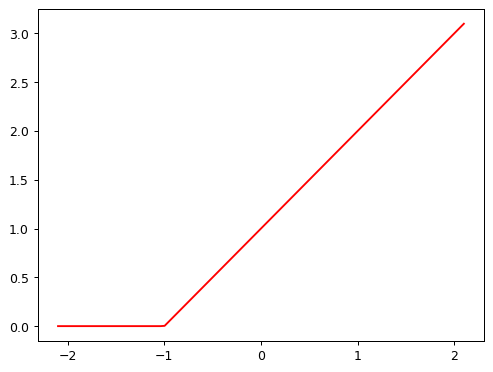

In [29]:
plot_function(partial(rectified_linear, 1,1))

Instead of torch.clip(y,0.), we can use F.relu(x) from the torch.nn.functional module

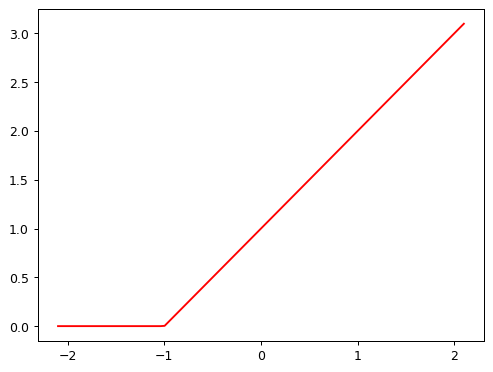

In [31]:
import torch.nn.functional as F
def rectified_linear2(m,b,x):
  return F.relu(m*x+b)

plot_function(partial(rectified_linear2,1,1))


To further explore this, we plot an interactive version where we can adjust the m and b parameters.

interactive(children=(FloatSlider(value=1.5, description='m', max=4.5, min=-1.5), FloatSlider(value=1.5, descr…

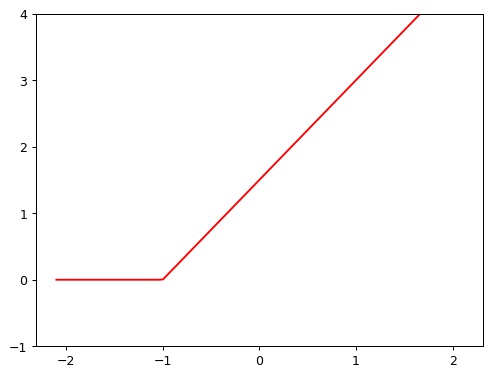

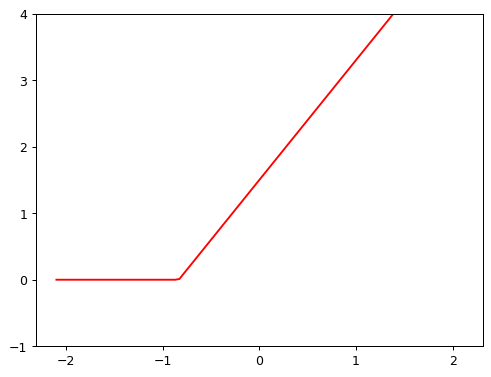

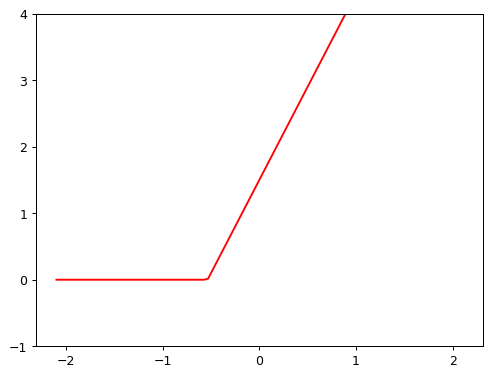

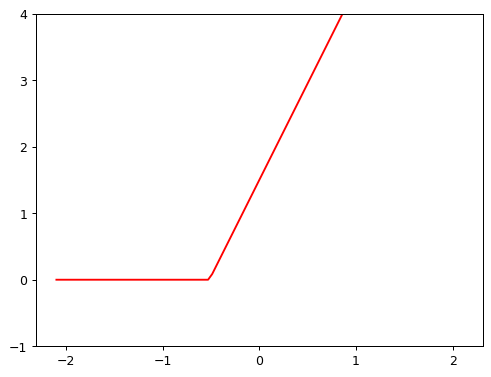

In [32]:
@interact(m=1.5, b=1.5)
def plot_relu(m, b):
    plot_function(partial(rectified_linear, m,b), ylim=(-1,4))

Adjusting m changes the slope while adjust b changes where the hook appears. To improve this, we can add 2 rectified linear functions. lets see what happens when we do this.

interactive(children=(FloatSlider(value=-1.5, description='m1', max=1.5, min=-4.5), FloatSlider(value=-1.5, de…

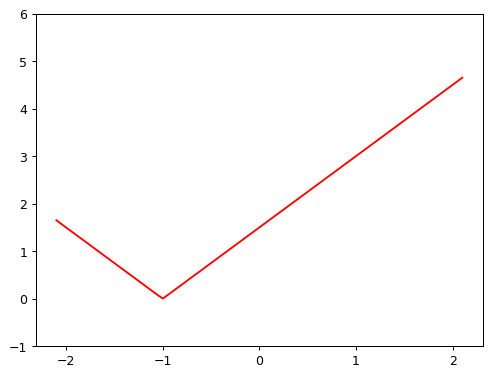

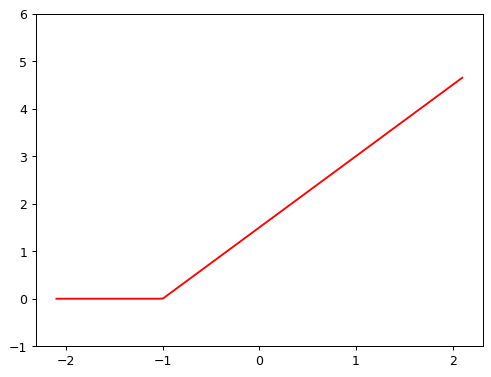

In [33]:
def double_relu(m1,b1,m2,b2,x):
    return rectified_linear(m1,b1,x) + rectified_linear(m2,b2,x)

@interact(m1=-1.5, b1=-1.5, m2=1.5, b2=1.5)
def plot_double_relu(m1, b1, m2, b2):
    plot_function(partial(double_relu, m1,b1,m2,b2), ylim=(-1,6))

Turns out if you play around with this for a while, you will notice that if we add a number of rectified linear function together, we can approximate any given function with a single input. Anytime the function doesnt quite fit, we can just add more additions to bring it closer.

 To quote the fastai book,


> OK great, we've created a nifty little example showing that we can drawing squiggly lines that go through some points. So what?
Well... the truth is that actually drawing squiggly lines (or planes, or high-dimensional hyperplanes...) through some points is literally all that deep learning does! If your data points are, say, the RGB values of pixels in photos of owls, then you can create an owl-recogniser model by following the exact steps above.



>  at a foundational level, there is no "step 2". We're done -- the above steps will, given enough time and enough data, create (for example) an owl recogniser, if you feed in enough owls (and non-owls).
The devil, I guess, is in the "given enough time and enough data" part of the above sentence. There's a lot of tweaks we can make to reduce both of these things. For instance, instead of running our calculations on a normal CPU, as we've done above, we could do thousands of them simultaneously by taking advantage of a GPU. We could greatly reduce the amount of computation and data needed by using a convolution instead of a matrix multiplication, which basically means skipping over a bunch of the multiplications and additions for bits that you'd guess won't be important. We could make things much faster if, instead of starting with random parameters, we start with parameters of someone else's model that does something similar to what we want (this is called transfer learning).





Acknowledments

https://www.kaggle.com/code/jhoward/how-does-a-neural-net-really-work

https://www.khanacademy.org/math/multivariable-calculus/applications-of-multivariable-derivatives/optimizing-multivariable-functions/a/what-is-gradient-descent

https://en.wikipedia.org/wiki/Gradient_descent

https://datascience.stackexchange.com/questions/82427/why-do-we-move-in-the-negative-direction-of-the-gradient-in-gradient-descent

